In [2]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

/home/dendav/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/home/dendav/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/dendav/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/dendav/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/dendav/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [6]:
X_train = X_train.float()
X_test = X_test.float()

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

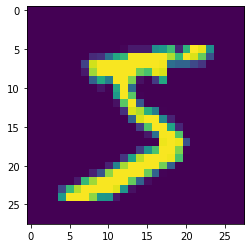

tensor(5)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [10]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [41]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.ac2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 10)
         
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)

        return x
    
mnist_net = MNISTNet(100)

In [42]:
torch.cuda.is_available()

True

In [43]:
!nvidia-smi

Tue Jun 21 13:50:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P5    N/A /  N/A |   1989MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0251,  0.0154, -0.0265,  ..., -0.0345,  0.0319,  0.0116],
         [-0.0326,  0.0121,  0.0266,  ..., -0.0350, -0.0170,  0.0121],
         [-0.0005, -0.0210, -0.0297,  ...,  0.0027,  0.0343,  0.0209],
         ...,
         [ 0.0203,  0.0047, -0.0343,  ..., -0.0313,  0.0138, -0.0060],
         [ 0.0015,  0.0134, -0.0081,  ..., -0.0142, -0.0223,  0.0336],
         [-0.0055, -0.0069,  0.0321,  ...,  0.0084,  0.0344,  0.0310]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0220, -0.0179,  0.0163,  0.0036,  0.0222,  0.0354, -0.0313,  0.0297,
         -0.0344, -0.0012,  0.0109, -0.0193,  0.0236, -0.0225, -0.0291, -0.0206,
         -0.0239,  0.0298,  0.0077, -0.0111, -0.0098, -0.0270, -0.0299, -0.0011,
         -0.0015,  0.0037, -0.0093, -0.0328, -0.0001, -0.0332,  0.0296, -0.0140,
          0.0275,  0.0296, -0.0334, -0.0355, -0.0208,  0.0072, -0.0157,  0.0339,
          0.0195, -0.0130, -0.0100, -0.0099,  0.0080, -0.0190,

In [45]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [46]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes] .to(device)
        y_batch = y_train[batch_indexes] .to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = float((test_preds.argmax(dim=1) == y_test).float().mean())
    test_accuracy_history.append(accuracy)
    print(accuracy)

0.8973000049591064
0.9068999886512756
0.9092999696731567
0.9159999489784241
0.923799991607666
0.9178999662399292
0.9279999732971191
0.9213999509811401
0.9291999936103821
0.9336999654769897
0.9334999918937683
0.9325000047683716
0.9316999912261963
0.9383999705314636
0.935699999332428
0.9390999674797058
0.9422999620437622
0.9395999908447266
0.9404999613761902
0.9447000026702881
0.9432999491691589
0.9440000057220459
0.9417999982833862
0.942799985408783
0.9430999755859375
0.9466999769210815
0.9465000033378601
0.9425999522209167
0.9432999491691589
0.9470999836921692
0.9456999897956848
0.9490000009536743
0.9513999819755554
0.9497999548912048
0.95169997215271
0.9515999555587769
0.9501999616622925
0.950499951839447
0.9515999555587769
0.9512999653816223
0.9517999887466431
0.9557999968528748
0.9511999487876892
0.9560999870300293
0.9541999697685242
0.9535999894142151
0.9556999802589417
0.9544999599456787
0.9562999606132507
0.9533999562263489
0.953499972820282
0.9544000029563904
0.9536999464035034


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 1.27 GiB already allocated; 8.75 MiB free; 1.28 GiB reserved in total by PyTorch)

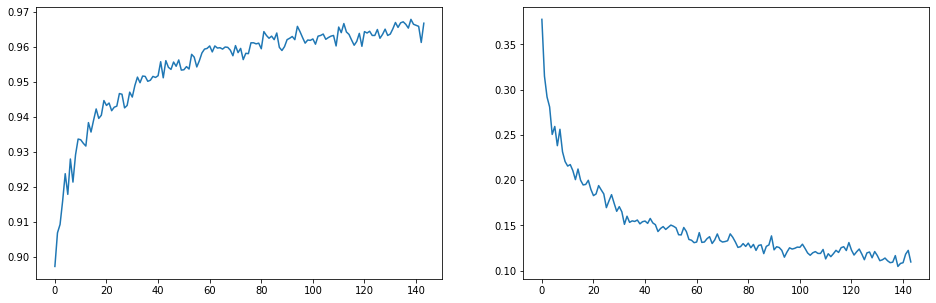

In [51]:
fig, ax = plt.subplots( 1,2, figsize=(16,5) )

ax[0].plot(list(map(float, test_accuracy_history)))
ax[1].plot(list(map(float, test_loss_history)));

tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(3, device='cuda:0') tensor(3, device='cuda:0')
tensor(8, device='cuda:0') tensor(8, device='cuda:0')


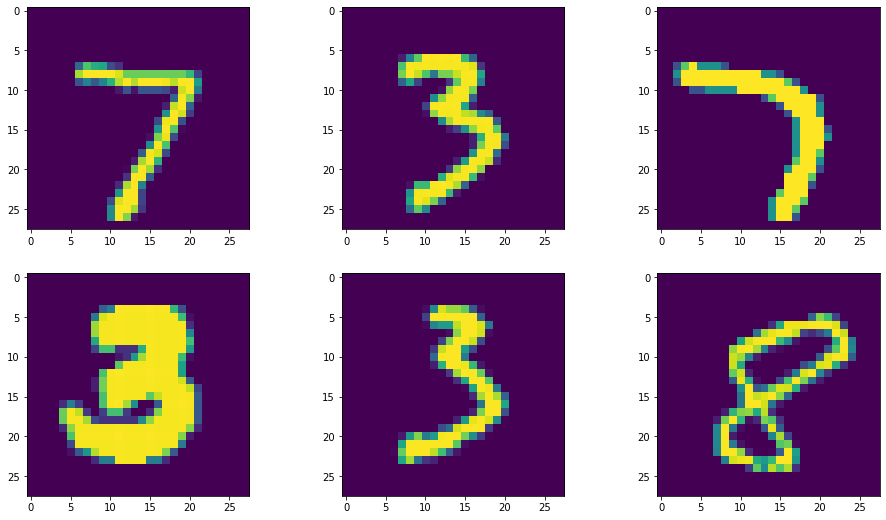

In [34]:
# Check how it detects in concrete examples
fig, ax = plt.subplots( 2,3, figsize=(16,9))

for i in range(2) :
    for j in range(3) :
        ax[i][j].imshow(X_test[200*i + 30*j].reshape([28,28]).cpu())
        print(mnist_net.forward(X_test[200*i + 30*j]).argmax(), y_test[200*i + 30*j])

In [23]:
aa = np.zeros((2,3))


IndexError: index 3 is out of bounds for axis 0 with size 2

## Task 4.4.2
В предыдущем шаге мы написали функцию, эмулирующую fc-слой. Проверим, что по ней правильно считается градиент. 

Функцию backward() в PyTorch можно посчитать только от скалярной функции (выход из такой функции – одно число). Это логично, так как loss-функция выдает всегда одно число. Но fc-слой, который мы проэмулировали, имел 3 выхода. Предлагаем их просуммировать, чтобы получить в итоге скалярную функцию. Заметим, впрочем, что можно было бы выбрать любую агрегирующую операцию, например умножение.

Дополните код так, чтобы градиент по весам и смещениям (bias) совпадал с аналогичным градиентом в вашей фунции.

Чем обусловлен полученный градиент? Изменится ли он, если мы подадим другие входы или другую инициализацию весов?

In [18]:
import torch

# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)
# Просуммируем выход fc-слоя, чтобы получить скаляр:
fc_out_summed = fc_out.sum()

# Посчитаем градиенты формулы fc_out_summed:
fc_out_summed.backward()
weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

# Ok, теперь воспроизведем вычисления выше но без fc-слоя:
# Проставим, что у "w" и "b" нужно вычислять градиенты (для fc-слоя это произошло автоматически):
w.requires_grad_(True)
b.requires_grad_(True)

# Получим выход нашей формулы:
our_formula = (x.mm(w.t()) + b).sum() # ... # SUM{x * w^T + b}

# Сделайте backward для нашей формулы:
our_formula.backward()

# Проверка осуществляется автоматически, вызовом функций:
print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)
# (раскомментируйте, если работаете над задачей локально)

fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])
